# Comparison between learning sensorimotor models 
## Part 1 : non parametric models

In this notebook, we compare the different sensorimotor models used in explauto in order to help the reader to use the most appropriate model depending on his aim. The notebook is split in two parts : non parametrics models (this notebook) and models based on gaussian mixtures (coming soon). There is also a tutorial explaining how to use the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel) ([learning_sensorimotor_models](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/learning_sensorimotor_models.ipynb)).

As explained in the [Explauto introduction](http://flowersteam.github.io/explauto/about.html), an important challenge in Developmental Robotics is how robots can efficiently learn sensorimotor mappings by experience, i.e. the mappings between the motor actions they make and the sensory effects they produce. This can be a robot learning how arm movements make physical objects move, or how movements of a virtual vocal tract modulates vocalization sounds.

Let's begin with defining a simple environment that will be used to test the sensorimotor models.

In [2]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'low_dimensional')

### Sensorimotor models introduction

In Explauto, a sensorimotor model implements both the iterative learning process from sensorimotor experience, i.e. from the iterative collection of $(m, s)$ pairs by interaction with the environment, and the use of the resulting internal model to perform forward and inverse predictions (or any kind of general prediction between sensorimotor subspaces). 

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Using the simple arm environment above, it allows to iteratively learn a sensorimotor model which will be able to:
* infer the position of the end-effector from a given motor command, what is called *forward prediction*,
* infer the motor command allowing to reach a particular end-effector position, what is called *inverse prediction*.
* update online from sensorimotor experience

### Decision tree

In order to use the most appropriate model, there are several questions that have to be asked before using the following decision tree. The following paragraphs focus on these questions.

*Add the decision tree*

### Non parametric or gaussian mixture models ? 

Each of non parametric model is currently based on the nearest neigbhor look up. They are non paramtric models because they don't rely on assomptions that the data are drown from a given probability while gassian mixture models (GMM) assumes that the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. Thus, the last model can be used only with gaussian distributed data. Readers in this case should refer to the follwing tutorial : *coming soom* .

### Presentation of the different non parametric models

Available non parametric sensorimotor models in Explauto can be accessed using: 

In [3]:
from explauto.sensorimotor_model import sensorimotor_models
print 'Available sensorimotor models: {}'.format(sensorimotor_models.keys())

Available sensorimotor models: ['LWLR-BFGS', 'nearest_neighbor', 'WNN', 'LWLR-CMAES']


These 4 models are a combination of a forward and an inverse model:
* the **nearest neighbor** model searches the nearest point of a given input ($m$ or $s$) in the dataset and returns its corresponding value (respectively $s$ or $m$)
* the **WNN or weighted nearest neighbor** model searches the $k$ nearest points of a given input ($m$ or $s$) in the dataset and returns the average of the $k$ corresponding values (respectively $m$ or $s$)
* the **LWLR or The Locally Weigthed Linear Regression (LWLR)** offers two inverses model for the same forward one. The forward computes a linear regression of the $k$ nearest neighbors of $m$ and find the requested $s$ with the given $m$ based on that regression. Both inverse models are optimisation algorithm that minimize the error  $e(m) = ||LWLR(m) - s_g||^2$  where $s_g$ is the goal, $LWLR$ is the forward model LWLR, and $m$ is the motor command to be infered. Both **LWLR-BFGS** and **LWLR-CMAES** use LWLR forward model to predict $s$ but LWLR-BFGF uses Broyden–Fletcher–Goldfarb–Shanno algorithm and LWLR-CMAES covariance matrix adaptation which are going to be explained later.
Let's see which of these 8 *(2 * 4)* possibilities is the best

### Forward or inverse model ?

The forward model uses the dataset for the forward prediction computation, and the inverse model uses the forward model, or directly the dataset to perform inverse prediction. In other words, forward models predict $s_p$ given a $m$ that might have never been observed, using the dataset of observations $(m,s)$ and inverse models infer a motor command $m$ that should be able to reach a given goal $s_g$.  

### Forward models comparison
For each model : 
* Output descrptions
* Processing description
* When should it (or not) be used
* Time processing
* Distance between sg et s

In [29]:
from scipy import spatial
import time

#Environment definition
from explauto.environment.environment import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

from explauto.sensorimotor_model import sensorimotor_models
from explauto import SensorimotorModel

#### Nearest Neighbor forward model


To perform a forward prediction, the Nearest Neighbor model just looks in the dataset of tuples $(m, s)$ for the nearest neighbor of the given $m$ motor command, and returns its corresponding $s$.
The algorithm comes from scipy library : [scipy.spatial.KDTree.query](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.KDTree.query.html) (with x = $s_g$, k=1, eps = 0, p = 2, radius = +inf). It returns distance and indexes of found nearest neighbors.
It works sufficiently well in different typical robotic applications but can be very long if the dataset's size exceed $10⁵$. 

Let's see how to use it and its results :

In [33]:
#Creation of the dataset
random_motors = environment.random_motors(n=1000)
    
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor']
model = sm_cls(environment.conf, **sm_configs['default'])

for m in random_motors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)

In [30]:
#Test of the model
test = environment.random_motors(n=50)
distance = []
timer = []

for mTest in test :
    start = time.time()
    sTest_pred = model.forward_prediction(mTest)
    end = time.time()
    sTest_eff = environment.compute_sensori_effect(mTest)
    distance.append(spatial.distance.pdist([sTest_pred,sTest_eff])[0])
    timer.append(end - start)

In [32]:
# Distance between the predictive and effectiv value
comparison = {}
comparison['NN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]
print comparison['NN']

[0.24177072005089387, 0.16694489498320747, 0.70232748022294833, 0.00026514530181884763, 0.00027393861162125976, 0.002167940139770508]


#DRAFT bac a sable

Populating the interactive namespace from numpy and matplotlib


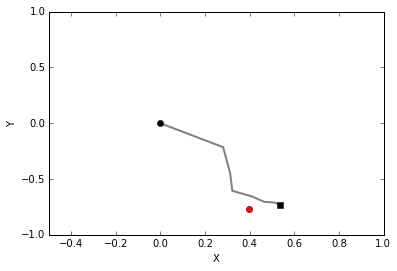

In [30]:
#NN TEST
for m in testing_couples
    
sTest_pred = model.forward_prediction(mTest)
distance["NN"] = abs(sTest_pred-sTest)

%pylab inline
ax = axes()
environment.plot_arm(ax, mTest)
ax.plot(*sTest_pred, marker='o', color='red')

Populating the interactive namespace from numpy and matplotlib


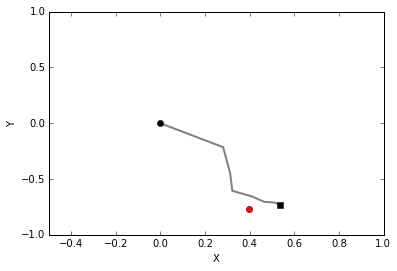

In [30]:
#NN TEST
for m in testing_couples
    
sTest_pred = model.forward_prediction(mTest)
distance["NN"] = abs(sTest_pred-sTest)

%pylab inline
ax = axes()
environment.plot_arm(ax, mTest)
ax.plot(*sTest_pred, marker='o', color='red')

Populating the interactive namespace from numpy and matplotlib


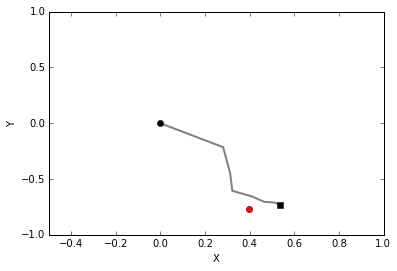

In [30]:
#NN TEST
for m in testing_couples
    
sTest_pred = model.forward_prediction(mTest)
distance["NN"] = abs(sTest_pred-sTest)

%pylab inline
ax = axes()
environment.plot_arm(ax, mTest)
ax.plot(*sTest_pred, marker='o', color='red')

In [31]:
sensorimotor_models.keys()
print mTest
print sTest
print distance.keys()

[-0.65232833 -0.78444065 -0.07154134  0.98469259 -0.20240519  0.59945435
 -0.5925971 ]
[ 0.54220714  0.79929109]
['NN']


[ 0.56816432 -0.60892505]
Populating the interactive namespace from numpy and matplotlib


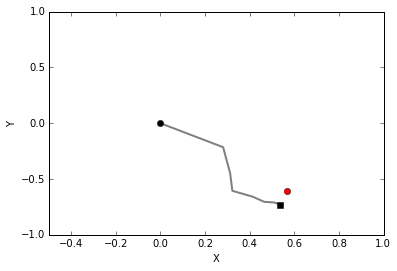

In [33]:
#KNN TEST
model = SensorimotorModel.from_configuration(environment.conf, 'WNN', 'default')

for m in random_motors:
    s = environment.compute_sensori_effect(m)
    # compute the sensori effect s of the motor command m through the environment
    model.update(m, s)
    
sTest_pred = model.forward_prediction(mTest)
print sTest_pred
distance["WNN"] = abs(sTest_pred-sTest)

%pylab inline
ax = axes()
environment.plot_arm(ax, mTest)
ax.plot(*sTest_pred, marker='o', color='red')

